# Оценка рассеивания методом статистических испытаний и обработка результатов

# Задания:
1) Для произвольного орудия проинтегрировать систему уравнений внешней баллистики для материальной точки

2) Произвольным образом задать разброс начальных скоростей, угла бросания, бокового угла, коэффициента формы и массы снаряда

3) Получить эллипс рассеивания

4) Проанализировать попадания

5) Доказать независимость величин X и Z

## READ ME
Программа делится на две части, в первой можно получить датасет, свободно варьируя параметры орудия, так же можно сделать произвольное число выстрелов. Для того, чтобы получить свой датасет, необходимо раскомментировать ячейки, которые идут до заголовка "Обработка данных" NB: внимательно, чтобы "data_of_shooting.csv" не перезаписывался/дописывался.

Вторая часть программы начинается от "Обработка данных". Вторая часть программы представляет собой обработку данных стрельбы

## Система уравнений
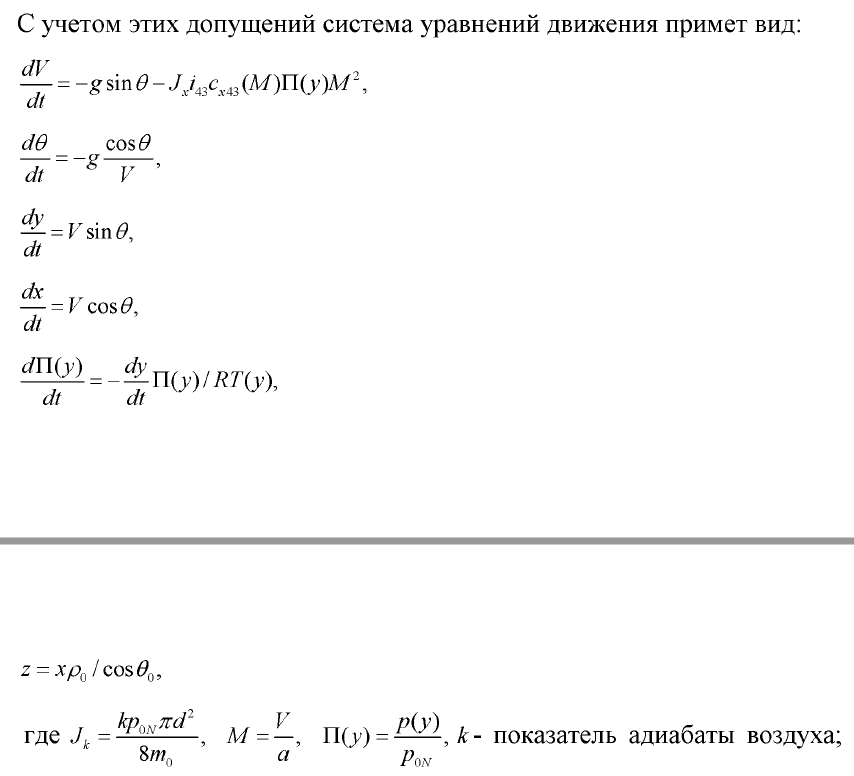

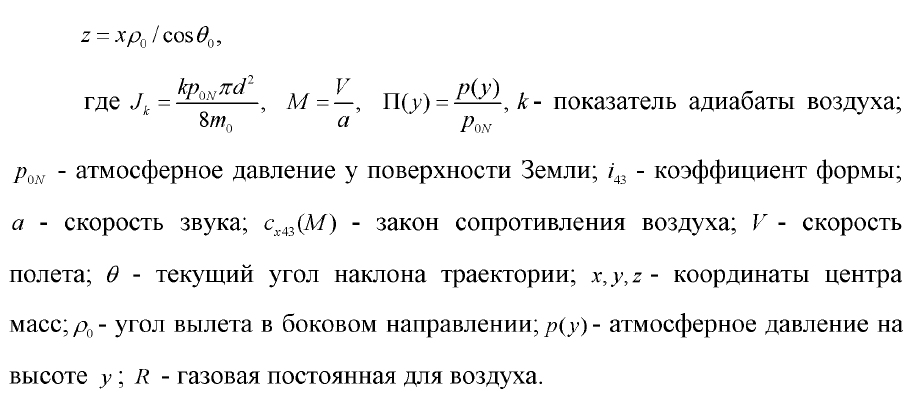

## Задание 1
Для произвольного орудия проинтегрировать систему уравнений внешней баллистики для материальной точки

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import ode
import seaborn as sns
from tqdm import tqdm
import pandas as pd

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 18})

In [2]:
#исходные данные
P_0N = 1.206 # плотность  на земле
tay_0N = 288.9 # температура на земле
p_0N = 0.99 * 10**5 # давление на земле
a_0N = 340.8 # скорость звука
g = 9.81 # ускор св пад
R = 287 # газов пост 
k = 1.24 # адиабата

In [3]:
d = 122/1000 # калибр орудия Аналог 2А18
m_0 = 21.6 # масса снаряда
v_0 = 540 # начальная скорость снаряда
i_43N = 0.3 # коэф формы снаряда
ro_0 = 0 # угол вылета в боковом направлении снаряда
tetta_0 = 40/180 * math.pi # угол бросания снаряда

In [4]:
# функция температуры от высоты
def tay(y):
    if y<=9300:
        return 286.9 - 0.006328*y
    elif (y>9300) and (y<=12000):
        return 230 - 0.006328*(y-9300) + 0.000001172*(y-9300)**2
    elif y>12000:
        return 221.5

In [5]:
# функция лобового сопротивления от скорости
def fun_c_x(v):
    M = v/a_0N
    if M<0.73:
        c_x = 0.157
    elif (M<0.82 and M>=0.73):
        c_x = 0.033*M+0.133
    elif (M<0.91 and M>=0.82):
        c_x = 0.161+3.9*(M-0.823)**2
    elif (M<1 and M>=0.91):
        c_x = 1.5*M-1.176
    elif (M<1.18 and M>=1):
        c_x = 0.384-1.6*(M-1.176)**2
    elif (M<1.62 and M>=1.18):
        c_x = 0.384*math.sin(1.85/M)
    elif (M<3.06 and M>=1.62):
        c_x = 0.29/M + 0.172
    elif (M<3.53 and M>=3.06):
        c_x = 0.316-0.016*M
    elif (M>=3.53):
        c_x = 0.259
        
    return c_x

In [6]:
# система уравнений внешней баллистики
def sistema(t, Y):
    
    v = Y[0]
    tetta = Y[1]
    y = Y[2]
    x = Y[3]
    P_ot_y = Y[4]
    
    dvdt = - k*p_0N*math.pi*d**2/(8*m_0) * i * fun_c_x(v) * P_ot_y * (v/a_0N)**2 - g*math.sin(tetta)
    dtettadt = -g*math.cos(tetta)/v
    dydt = v*math.sin(tetta)
    dxdt = v*math.cos(tetta)
    dP_ot_ydt = -dydt * P_ot_y/(R*tay(y))
    
    return np.array([dvdt,dtettadt,dydt,dxdt,dP_ot_ydt])

In [7]:
# начальные параметры
t_0 = 0  # время
v_0 = 540 # скорость
x_0 = 0 # нач координата абсцисс
y_0 = 0 # нач координата ординат
tetta_0 = 40/180 * math.pi # нач угол бросания
P_ot_y_0 = 1 # отношение давлений на тек высоте к давлению на нулевой высоте
ro_0 = 0 # угол вылета в бок направ
i = 0.3 # коэф формы снаряда

# вектор начальных параметров
Y_0 = [v_0,tetta_0,y_0,x_0,P_ot_y_0]

# интегрирование методом "backward differentiation formulas"
res = ode(sistema).set_integrator('vode', method='bdf')
res.set_initial_value(Y_0, t_0)
dt = 5e-1 # шаг по времени

v_arr = [] # массив скоростей
tetta_arr = [] # массив углов
y_arr = [] # массив у
x_arr = [] # массив х
z_arr = [] # массив бокового отклонения
P_ot_y_arr = [] # массив отнош давлений
t_arr = [] # массив времени


while (res.successful() and res.y[2] >= 0):
    v_arr.append(res.y[0])
    tetta_arr.append(res.y[1])
    y_arr.append(res.y[2])
    x_arr.append(res.y[3])
    P_ot_y_arr.append(res.y[4])
    t_arr.append(res.t+dt)
    a = (res.t+dt, res.integrate(res.t+dt))

Расчет точки попадания при заданных начальных параметрах 

In [8]:
# пересчет бокового отклонения от точки прицеливания по z
z_etalon = x_arr[-1]*ro_0/math.cos(tetta_0)
z_etalon

0.0

In [9]:
# расчет положения точки прицеливания по х
x_etalon = x_arr[-1]
x_etalon

18937.098483218855

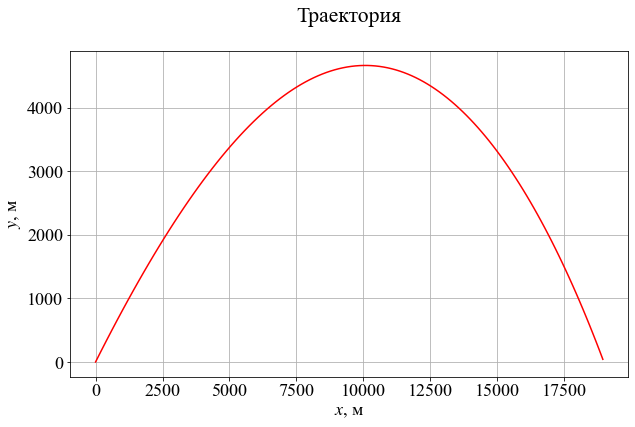

In [10]:
plt.figure(figsize=(10,6))
plt.plot(x_arr, y_arr,color='red')
plt.xlabel('$x$, м', fontsize=18)
plt.ylabel('$y$, м', fontsize=18)
plt.title('Траектория\n')
plt.grid()

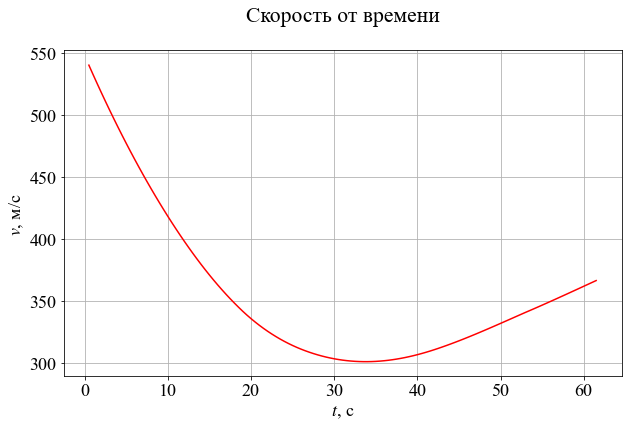

In [11]:
plt.figure(figsize=(10,6))
plt.plot(t_arr, v_arr,color='red')
plt.xlabel('$t$, c', fontsize=18)
plt.ylabel('$v$, м/c', fontsize=18)
plt.title('Скорость от времени\n')
plt.grid()

In [12]:
d = 122/1000 # калибр орудия Аналог 2А18
m_0 = 21.6 # масса снаряда
v_0 = 540 # начальная скорость снаряда
i_43N = 0.3 # коэф формы снаряда
ro_0 = 0 # угол вылета в боковом направлении снаряда
tetta_0 = 40/180 * math.pi # угол бросания снаряда

In [13]:
N = 100_000 # число розыгрышей(выстрелов)

## Задание 2
Произвольным образом задать разброс начальных скоростей, угла бросания, бокового угла, коэффициента формы и массы снаряда

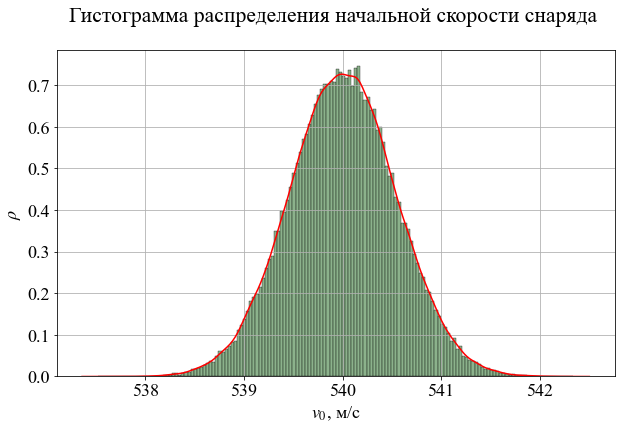

In [14]:
# распределние начальной скорости
v_0_mas = np.random.normal(v_0,0.1*10**(-2)*v_0,N)

# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(v_0_mas, stat = 'density', color='#669966')
sns.kdeplot(v_0_mas, color='red')
plt.title('Гистограмма распределения начальной скорости снаряда \n')
plt.xlabel(r'$v_0$, м/c', fontsize=18)
plt.ylabel(r'$\rho$', fontsize=18)
plt.grid()
plt.savefig('v_0_hist',dpi = 300)

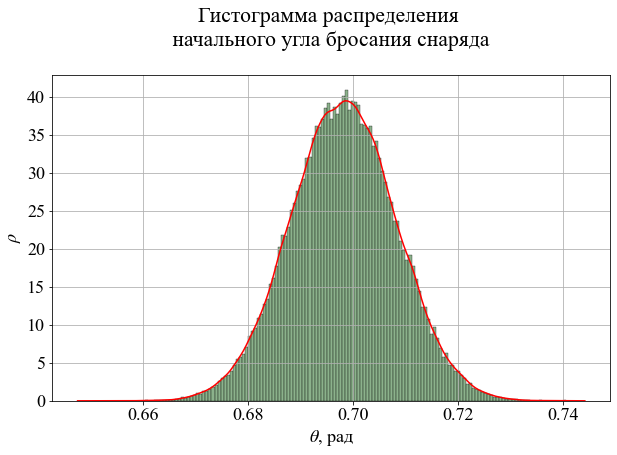

In [15]:
# распределние начального угла бросания
tetta_0_mas = np.random.normal(tetta_0,0.01,N)

# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(tetta_0_mas, stat = 'density', color='#669966')
sns.kdeplot(tetta_0_mas, color='red')
plt.title('Гистограмма распределения \n начального угла бросания снаряда \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel('$θ$, рад', fontsize=18)
plt.grid()
plt.savefig('tetta_0_hist',dpi = 300)

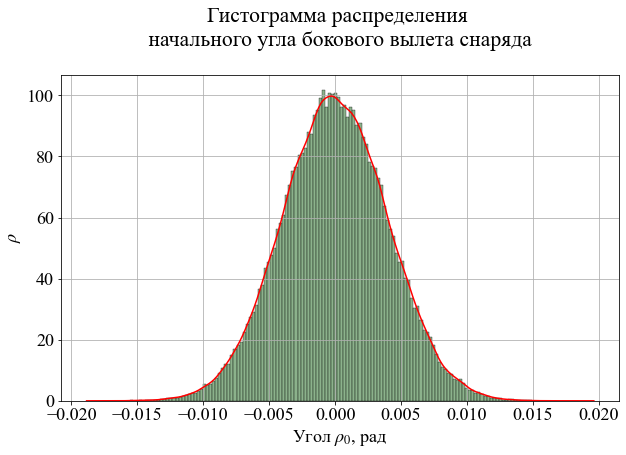

In [16]:
# распределние начального угла бокового вылета
ro_0_mas = np.random.normal(ro_0,0.004,N)

# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(ro_0_mas, stat = 'density', color='#669966')
sns.kdeplot(ro_0_mas, color='red')
plt.title('Гистограмма распределения \n начального угла бокового вылета снаряда \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel(r'Угол $\rho_0$, рад', fontsize=18)
plt.grid()
plt.savefig('rho_0_hist',dpi = 300)

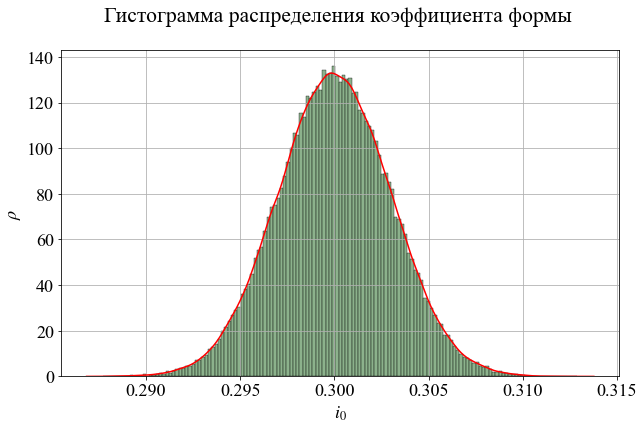

In [17]:
# распределние коэф формы
i_0_mas = np.random.normal(i_43N,0.01*i_43N,N)

# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(i_0_mas, stat = 'density', color='#669966')
sns.kdeplot(i_0_mas, color='red')
plt.title('Гистограмма распределения коэффициента формы \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel('$i_0$', fontsize=18)
plt.grid()
plt.savefig('i_0_hist',dpi = 300)

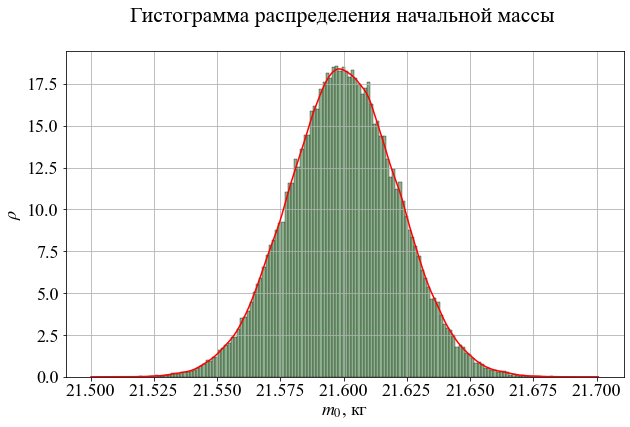

In [18]:
# распределние начальной массы
m_0_mas = np.random.normal(m_0,0.001*m_0,N)

# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(m_0_mas, stat = 'density', color='#669966')
sns.kdeplot(m_0_mas, color='red')
plt.title('Гистограмма распределения начальной массы \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel('$m_0$, кг', fontsize=18)
plt.grid()
plt.savefig('m_0_hist',dpi = 300)

Перемешаем массивы ошибки

In [19]:
import random
random.shuffle(v_0_mas)
random.shuffle(tetta_0_mas)
random.shuffle(m_0_mas)
random.shuffle(ro_0_mas)
random.shuffle(i_0_mas)

## Задание 3
Получить эллипс рассеивания

In [20]:
# Решение задачи, время расчета 100_000 точек ~ 4.2 минуты 16RAM i7-1165, 
# если спрятать a = (res.t+dt, res.integrate(res.t+dt)), то все ломается -_-

x_rez = []
z_rez = []

for i in tqdm(range(N)):
    t_0 = 0
    v_0 = v_0_mas[i]
    x_0 = 0
    y_0 = 0
    tetta_0 = tetta_0_mas[i]
    m_0 = m_0_mas[i]
    P_ot_y_0 = 1
    ro_0 = ro_0_mas[i]
    i = i_0_mas[i]


    Y_0 = [v_0,tetta_0,y_0,x_0,P_ot_y_0]

    res = ode(sistema).set_integrator('vode', method='bdf')
    res.set_initial_value(Y_0, t_0)
    dt = 5e-1

    v_arr = []
    tetta_arr = []
    y_arr = []
    x_arr = []
    z_arr = []
    P_ot_y_arr = []
    t_arr = []


    while (res.successful() and res.y[2] >= 0):
        v_arr.append(res.y[0])
        tetta_arr.append(res.y[1])
        y_arr.append(res.y[2])
        x_arr.append(res.y[3])
        P_ot_y_arr.append(res.y[4])
        t_arr.append(res.t+dt)
        a = (res.t+dt, res.integrate(res.t+dt)) # чтоб работало
    

    x_rez.append(x_arr[-1])
    z_rez.append(x_arr[-1]*ro_0/math.cos(tetta_0))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:15<00:00, 391.53it/s]


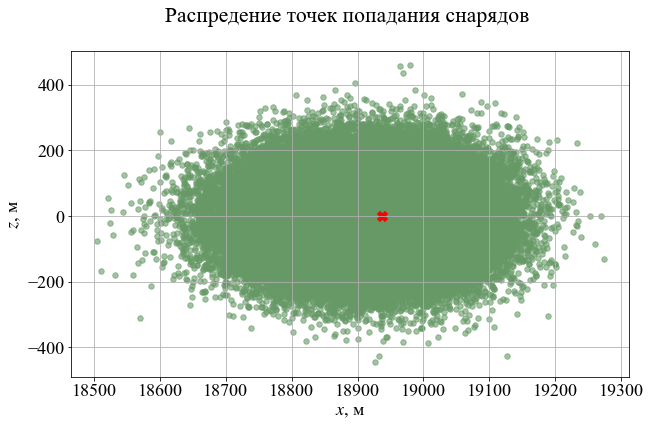

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(x_rez, z_rez,s=30, alpha=0.6, color='#669966')
plt.scatter(x_etalon, z_etalon, s=100, alpha=1, marker='X', color = 'red')
plt.title('Распредение точек попадания снарядов \n')
plt.xlabel('$x$, м', fontsize=18)
plt.ylabel('$z$, м', fontsize=18)
plt.grid()

In [22]:
df = pd.DataFrame({'x':x_rez,
                   'z':z_rez,'v_0':v_0_mas,
                   'tetta_0':tetta_0_mas, 'm_0':m_0_mas,
                   'ro_0':ro_0_mas, 'i_0':i_0_mas})

In [23]:
df.head()

,x,z,v_0,tetta_0,m_0,ro_0,i_0
0,18916.656834,-132.224660,539.068019,0.699490,21.592000,-0.005348,0.298562
1,18941.224266,-74.259161,540.376482,0.704963,21.609482,-0.002986,0.304735
2,18987.193898,139.736186,539.262883,0.714134,21.615318,0.005561,0.300295
3,18856.452083,-87.649803,540.503030,0.699161,21.593506,-0.003558,0.307105
4,18889.041756,-39.815889,539.678967,0.702925,21.612046,-0.001608,0.299225


In [24]:
# restart kernel, очистим память
df.to_csv('data_of_shooting.csv',index=False)

## Обработка данных

In [25]:
df = pd.read_csv('data_of_shooting.csv')

In [26]:
df.head()

,x,z,v_0,tetta_0,m_0,ro_0,i_0
0,18916.656834,-132.224660,539.068019,0.699490,21.592000,-0.005348,0.298562
1,18941.224266,-74.259161,540.376482,0.704963,21.609482,-0.002986,0.304735
2,18987.193898,139.736186,539.262883,0.714134,21.615318,0.005561,0.300295
3,18856.452083,-87.649803,540.503030,0.699161,21.593506,-0.003558,0.307105
4,18889.041756,-39.815889,539.678967,0.702925,21.612046,-0.001608,0.299225


## Задание 2
Произвольным образом задать разброс начальных скоростей, угла бросания, бокового угла, коэффициента формы и массы снаряда

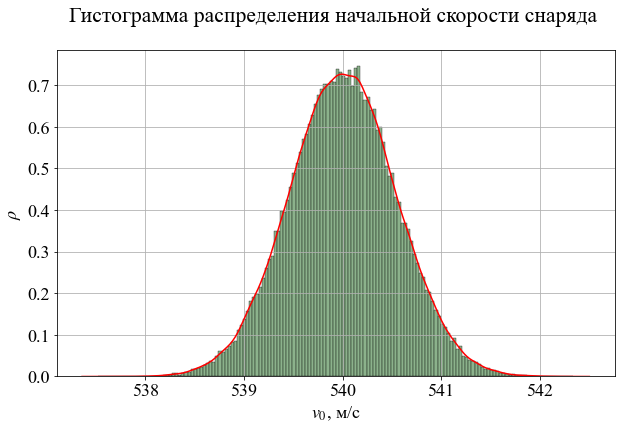

In [27]:
# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(df.v_0, stat = 'density', color='#669966')
sns.kdeplot(df.v_0, color='red')
plt.title('Гистограмма распределения начальной скорости снаряда \n')
plt.xlabel(r'$v_0$, м/c', fontsize=18)
plt.ylabel(r'$\rho$', fontsize=18)
plt.grid()
plt.savefig('v_0_hist',dpi = 300)

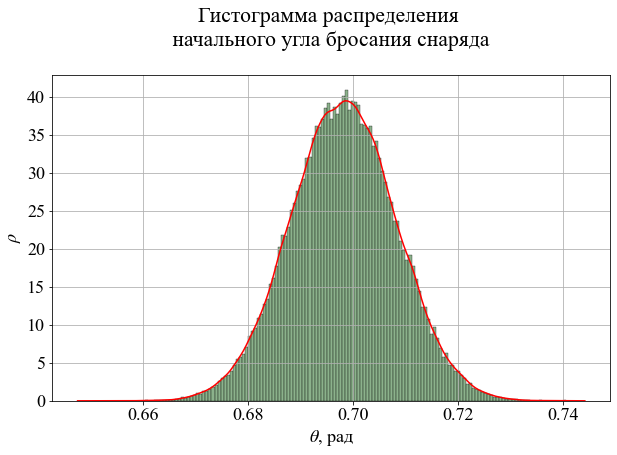

In [28]:
# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(df.tetta_0, stat = 'density', color='#669966')
sns.kdeplot(df.tetta_0, color='red')
plt.title('Гистограмма распределения \n начального угла бросания снаряда \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel('$θ$, рад', fontsize=18)
plt.grid()
plt.savefig('tetta_0_hist',dpi = 300)

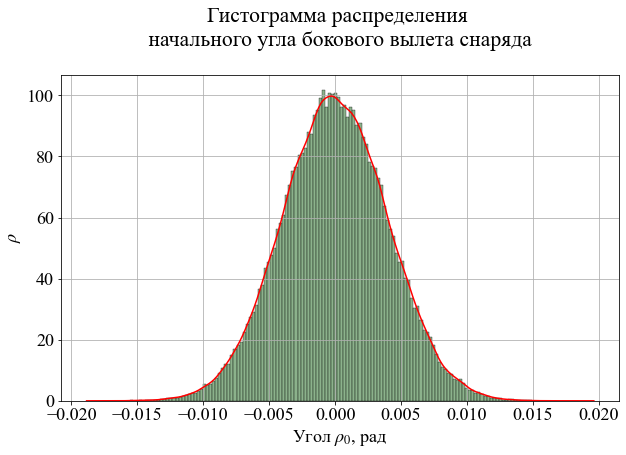

In [29]:
# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(df.ro_0, stat = 'density', color='#669966')
sns.kdeplot(df.ro_0, color='red')
plt.title('Гистограмма распределения \n начального угла бокового вылета снаряда \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel(r'Угол $\rho_0$, рад', fontsize=18)
plt.grid()
plt.savefig('rho_0_hist',dpi = 300)

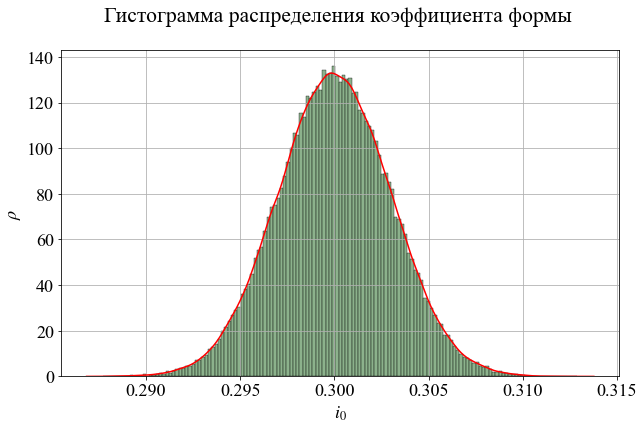

In [30]:
# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(df.i_0, stat = 'density', color='#669966')
sns.kdeplot(df.i_0, color='red')
plt.title('Гистограмма распределения коэффициента формы \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel('$i_0$', fontsize=18)
plt.grid()
plt.savefig('i_0_hist',dpi = 300)

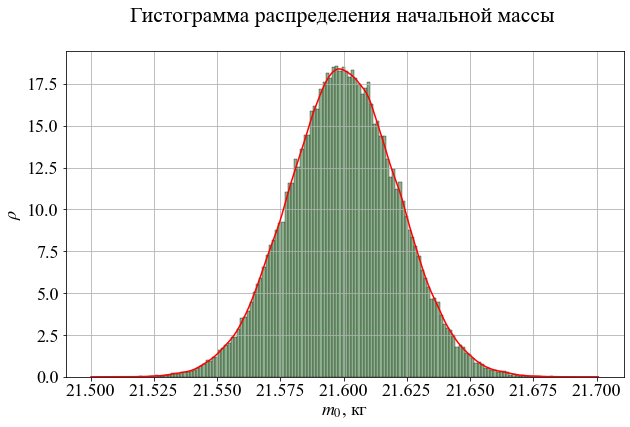

In [31]:
# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(df.m_0, stat = 'density', color='#669966')
sns.kdeplot(df.m_0, color='red')
plt.title('Гистограмма распределения начальной массы \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel('$m_0$, кг', fontsize=18)
plt.grid()
plt.savefig('m_0_hist',dpi = 300)

## Задание 3
Получить эллипс рассеивания

In [32]:
df = df.assign(x_diff = df.x - x_etalon,
          z_diff = df.z - z_etalon)

In [33]:
df.describe()

,x,z,v_0,tetta_0,m_0,ro_0,i_0,x_diff,z_diff
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,18910.267339,-0.244486,540.001200,0.698128,21.599929,-0.000010,0.300002,-26.831144,-0.244486
std,90.658408,98.485483,0.541948,0.009981,0.021603,0.003989,0.002997,90.658408,98.485483
min,18503.829006,-444.110530,537.519100,0.650550,21.506681,-0.017660,0.287746,-433.269477,-444.110530
25%,18849.436547,-67.060584,539.636916,0.691395,21.585398,-0.002714,0.297985,-87.661936,-67.060584
50%,18911.250973,-0.667122,540.002318,0.698134,21.599909,-0.000027,0.299997,-25.847510,-0.667122
75%,18972.144005,66.348035,540.365225,0.704854,21.614519,0.002687,0.302028,35.045522,66.348035
max,19274.277532,458.475625,542.341843,0.741071,21.694244,0.018420,0.312877,337.179049,458.475625


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   x        100000 non-null  float64
 1   z        100000 non-null  float64
 2   v_0      100000 non-null  float64
 3   tetta_0  100000 non-null  float64
 4   m_0      100000 non-null  float64
 5   ro_0     100000 non-null  float64
 6   i_0      100000 non-null  float64
 7   x_diff   100000 non-null  float64
 8   z_diff   100000 non-null  float64
dtypes: float64(9)
memory usage: 6.9 MB


In [35]:
df.isna().sum()

x          0
z          0
v_0        0
tetta_0    0
m_0        0
ro_0       0
i_0        0
x_diff     0
z_diff     0
dtype: int64

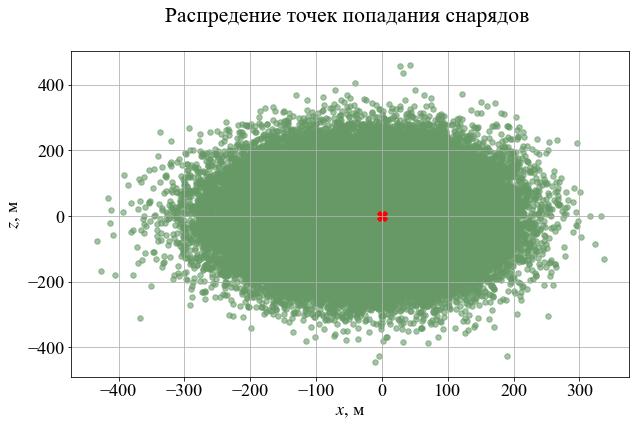

In [36]:
plt.figure(figsize=(10,6))
plt.scatter(df.x_diff, df.z_diff, s=30, alpha=0.6, color='#669966')
plt.scatter(0, 0, s=100, alpha=1, marker='X', color = 'red')
plt.title('Распредение точек попадания снарядов \n')
plt.xlabel('$x$, м', fontsize=18)
plt.ylabel('$z$, м', fontsize=18)
plt.grid()

## Задание 4
Проанализировать попадания

Text(0.0, 1.0, 'Распредение точек \nпопадания снарядов')

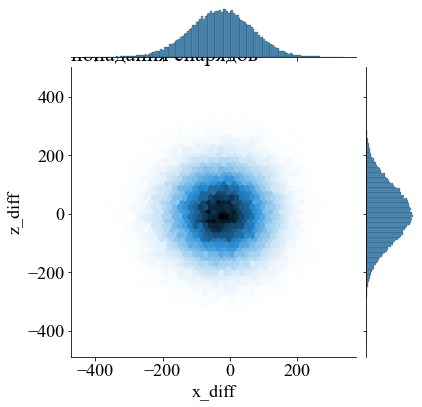

In [37]:
sns.jointplot(data=df, x="x_diff", y="z_diff", kind="hex")
plt.title('Распредение точек \nпопадания снарядов', loc='left')

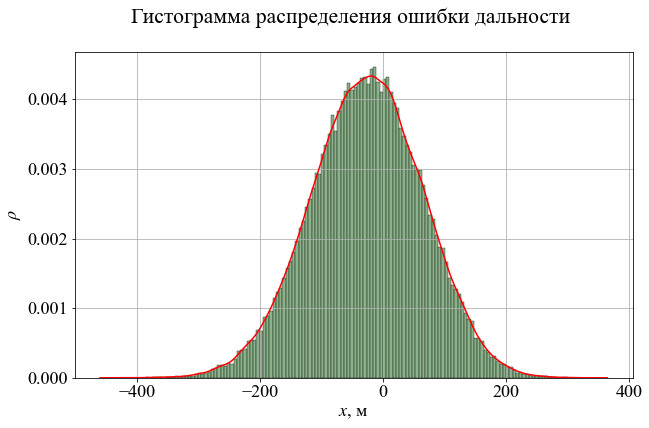

In [38]:
# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(df.x_diff, stat = 'density', color='#669966')
sns.kdeplot(df.x_diff, color='red')
plt.title('Гистограмма распределения ошибки дальности \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel('$x$, м', fontsize=18)
plt.grid(True)
plt.savefig('x_hist',dpi = 300)

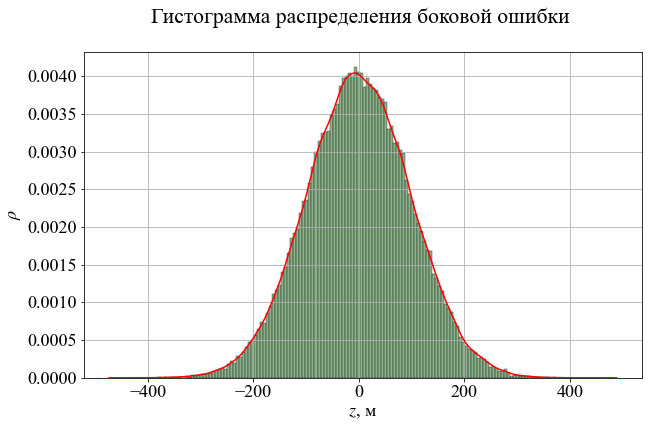

In [39]:
# Визуализация
plt.figure(figsize=(10,6))
sns.histplot(df.z_diff, stat = 'density', color='#669966')
sns.kdeplot(df.z_diff, color='red')
plt.title('Гистограмма распределения боковой ошибки \n')
plt.ylabel(r'$\rho$', fontsize=18)
plt.xlabel('$z$, м', fontsize=18)
plt.grid(True)
plt.savefig('z_hist',dpi = 300)

In [40]:
df.z_diff

0       -132.224660
1        -74.259161
2        139.736186
3        -87.649803
4        -39.815889
            ...    
99995     31.204851
99996    154.601594
99997     28.151430
99998   -153.479176
99999     49.596739
Name: z_diff, Length: 100000, dtype: float64

In [41]:
# Радиус от эталонной точки
bins = [0,5,10,20,40,80,1000]
df['r_diff'] = pd.cut((abs(df.z_diff)**2+abs(df.x_diff)**2)**(1/2), bins, labels=["r<5", "5<r<10", "10<r<20",
                                                                                  "20<r<40", "40<r<80", "r>80"])

In [42]:
df.groupby('r_diff',as_index=False).agg({'x':'count'})

,r_diff,x
0,r<5,131
1,5<r<10,404
2,10<r<20,1619
3,20<r<40,6052
4,40<r<80,20725
5,r>80,71069


In [43]:
df.query('r_diff == "r<5"').describe()

,x,z,v_0,tetta_0,m_0,ro_0,i_0,x_diff,z_diff
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,18937.345238,-0.027817,539.995703,0.700812,21.602155,-0.000001,0.299737,0.246755,-0.027817
std,2.652050,2.461693,0.476686,0.006860,0.020459,0.000099,0.002429,2.652050,2.461693
min,18932.428185,-4.940232,538.715979,0.687980,21.552773,-0.000199,0.293866,-4.670298,-4.940232
25%,18935.201692,-1.857517,539.694474,0.697492,21.587839,-0.000075,0.298272,-1.896791,-1.857517
50%,18937.341012,-0.416129,539.960537,0.699780,21.605232,-0.000017,0.299962,0.242529,-0.416129
75%,18939.612022,2.008524,540.294613,0.706353,21.614930,0.000082,0.301575,2.513538,2.008524
max,18941.940151,4.724365,541.133942,0.717882,21.650591,0.000190,0.305477,4.841668,4.724365


## Задание 5
Доказать независимость величин X и Z

### Коэффициент корреляции
Между величинами крайне мал, следовательно величины X и Z - независимые, и оси эллипса рассеивания парралельны осям X и Z

In [44]:
df.corr(method ='kendall')

,x,z,v_0,tetta_0,m_0,ro_0,i_0,x_diff,z_diff
x,1.000000,-0.000186,0.166093,0.453023,0.037886,-0.000157,-0.383590,1.000000,-0.000186
z,-0.000186,1.000000,0.001361,0.004011,-0.000282,0.995645,0.006165,-0.000186,1.000000
v_0,0.166093,0.001361,1.000000,0.000427,0.003495,0.001372,0.000927,0.166093,0.001361
tetta_0,0.453023,0.004011,0.000427,1.000000,0.002045,0.004040,-0.001100,0.453023,0.004011
m_0,0.037886,-0.000282,0.003495,0.002045,1.000000,-0.000257,-0.001046,0.037886,-0.000282
ro_0,-0.000157,0.995645,0.001372,0.004040,-0.000257,1.000000,0.006144,-0.000157,0.995645
i_0,-0.383590,0.006165,0.000927,-0.001100,-0.001046,0.006144,1.000000,-0.383590,0.006165
x_diff,1.000000,-0.000186,0.166093,0.453023,0.037886,-0.000157,-0.383590,1.000000,-0.000186
z_diff,-0.000186,1.000000,0.001361,0.004011,-0.000282,0.995645,0.006165,-0.000186,1.000000
